In [ ]:
import os, sys
from pathlib import Path

_root = next((p for p in [Path(os.getcwd()), *Path(os.getcwd()).parents]
              if p.name == 'cryptoTrading2'), None)
if _root:
    os.chdir(str(_root))
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from files.functions import (
    base_dir,
    fullDataPath,
    dataSetup,
    trainingCols,
    _prophet_param_grid,
    _prophet_tune,
    _prophet_scale,
    _prophet_build_train_frame,
    _prophet_train_single,
    _prophet_future_forecast,
    _prophet_make_future,
    _prophet_time_split,
    _prophet_inverse_target,
    _save_prophet_model,
    _standardized_rmse,
    _save_metrics,
    ProphetWrapper,
)
from files.CONSTANTS import COIN, RESPONSE_VARIABLE, TRAINING_COLUMNS, TEST_DAYS, TRAIN_PCT, LIMIT

# Prophet Training

Facebook Prophet model with additional regressors for crypto price prediction.
This notebook loads the full feature set, tunes Prophet hyperparameters
(`seasonality_mode`, `changepoint_prior_scale`, `seasonality_prior_scale`, Fourier order)
alongside scaler selection, retrains the best configuration on full data,
and produces both validation and future price predictions.

Dataset shape: (730, 25)
Feature columns (23): ['open', 'high', 'low', 'volume', 'value', 'SMA_7', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'EMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_STD', 'Volume_MA_7', 'OBV', 'avg_sentiment']
Target: close
Date range: 2024-02-24 00:00:00 → 2026-02-22 00:00:00


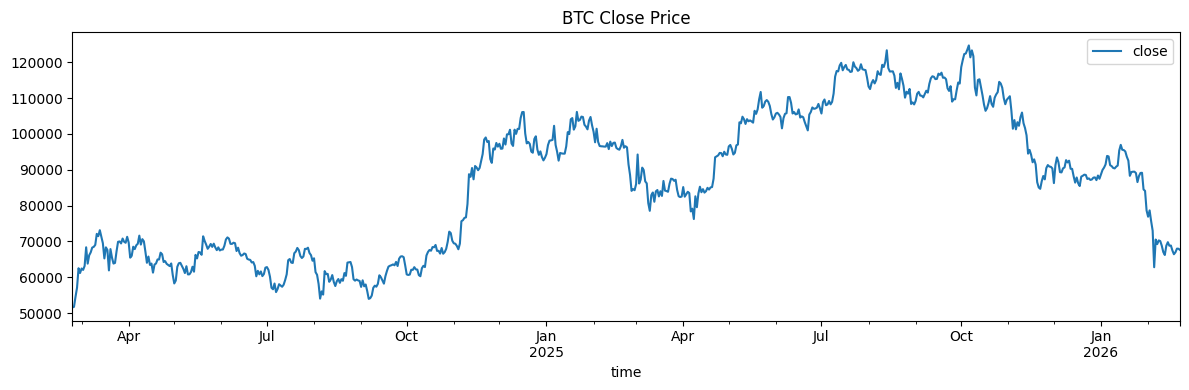


Total rows: 730  |  Train: 584  |  Val: 146


In [2]:
# ── Step 1: Load Data ────────────────────────────────────────────────────────
raw_path = fullDataPath(COIN)
data = pd.read_csv(raw_path)
daily_data = dataSetup(data, trainingColPath=TRAINING_COLUMNS, response=RESPONSE_VARIABLE, number=LIMIT)
features = trainingCols(TRAINING_COLUMNS)
print(f"Dataset shape: {daily_data.shape}")
print(f"Feature columns ({len(features)}): {features}")
print(f"Target: {RESPONSE_VARIABLE}")
print(f"Date range: {daily_data.index[0]} → {daily_data.index[-1]}")

daily_data[[RESPONSE_VARIABLE]].plot(title=f"{COIN} Close Price", figsize=(12, 4))
plt.tight_layout()
plt.show()

# Train/val split info (Prophet tuning handles this internally)
n = len(daily_data)
split_idx = max(1, int(n * TRAIN_PCT))
print(f"\nTotal rows: {n}  |  Train: {split_idx}  |  Val: {n - split_idx}")

In [3]:
# ── Step 3: Define Hyperparameter Grid ───────────────────────────────────────
param_grid = _prophet_param_grid()
scaler_methods = ['standard', 'minmax', 'robust']

print(f"Prophet param grid size: {len(param_grid)} configs")
print(f"Scaler methods: {scaler_methods}")
print(f"Total combinations: {len(param_grid) * len(scaler_methods)}")
print("\nSample configs:")
for cfg in param_grid[:3]:
    print(" ", cfg)

Prophet param grid size: 72 configs
Scaler methods: ['standard', 'minmax', 'robust']
Total combinations: 216

Sample configs:
  {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_fourier_order': 3, 'yearly_seasonality': True}
  {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_fourier_order': 3, 'yearly_seasonality': False}
  {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0, 'weekly_fourier_order': 5, 'yearly_seasonality': True}


In [4]:
# ── Step 4: Tune Hyperparameters (incl. scaler) ───────────────────────────────
print("Running Prophet tuning (this may take a few minutes)...")
best_combo, tuning_results = _prophet_tune(
    daily_data, features, RESPONSE_VARIABLE, TRAIN_PCT,
    scaler_methods=scaler_methods
)

if best_combo is None:
    raise RuntimeError("Prophet tuning failed to find a valid model configuration.")

print(f"\nBest scaler method: {best_combo['scaler_method']}")
print(f"Best params:")
for k, v in best_combo['params'].items():
    print(f"  {k}: {v}")
print(f"Best RMSE: {best_combo['rmse']:,.2f}")
print(f"Best std RMSE: {best_combo['standardized_rmse']:.4f}")

# Show top-5 results by standardized RMSE
tuning_df = pd.DataFrame(tuning_results).sort_values('standardized_rmse').reset_index(drop=True)
print("\nTop-5 tuning results:")
display_cols = ['seasonality_mode', 'changepoint_prior_scale', 'seasonality_prior_scale',
                'scaler', 'rmse', 'standardized_rmse']
available_cols = [c for c in display_cols if c in tuning_df.columns]
print(tuning_df[available_cols].head(5).to_string(index=False))

21:38:00 - cmdstanpy - INFO - Chain [1] start processing


Running Prophet tuning (this may take a few minutes)...


21:38:00 - cmdstanpy - INFO - Chain [1] done processing
21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing
21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing
21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing
21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:01 - cmdstanpy - INFO - Chain [1] done processing
21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:01 - cmdstanpy - INFO - Chain [1] done processing
21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:01 - cmdstanpy - INFO - Chain [1] done processing
21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:01 - cmdstanpy - INFO - Chain [1] done processing
21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:01 - cmdstanpy - INFO - Chain [1] done processing
21:38:01 - cmdstanpy - INFO - Chain [1] 


Best scaler method: minmax
Best params:
  changepoint_prior_scale: 0.01
  seasonality_mode: multiplicative
  seasonality_prior_scale: 5.0
  weekly_fourier_order: 5
  yearly_seasonality: False
Best RMSE: 836.74
Best std RMSE: 0.0575

Top-5 tuning results:
seasonality_mode  changepoint_prior_scale  seasonality_prior_scale scaler       rmse  standardized_rmse
  multiplicative                     0.01                      5.0 minmax 836.741760           0.057511
  multiplicative                     0.01                      1.0 minmax 849.924947           0.058417
        additive                     0.01                      5.0 robust 855.156085           0.058777
  multiplicative                     0.01                     10.0 minmax 856.675322           0.058881
  multiplicative                     0.01                      1.0 minmax 860.725957           0.059160


In [5]:
# ── Step 5: Retrain Best Config on Full Dataset ───────────────────────────────
best_scaler_method = best_combo['scaler_method']
best_params = best_combo['params']

# Scale full dataset
df_scaled_full, feature_scaler, target_scaler = _prophet_scale(
    daily_data, features, RESPONSE_VARIABLE, best_scaler_method
)
full_train_df = _prophet_build_train_frame(df_scaled_full, RESPONSE_VARIABLE)

# Train final Prophet model
print(f"Training final Prophet model with scaler='{best_scaler_method}' on full dataset ({len(full_train_df)} rows)...")
final_model = _prophet_train_single(full_train_df, features, best_params)
print("Final model trained.")

# Wrap model with scalers for downstream use
wrapper = ProphetWrapper(
    final_model, target_scaler, feature_scaler, features,
    best_scaler_method, best_params
)
print(f"ProphetWrapper created.")

21:38:56 - cmdstanpy - INFO - Chain [1] start processing
21:38:56 - cmdstanpy - INFO - Chain [1] done processing


Training final Prophet model with scaler='minmax' on full dataset (730 rows)...
Final model trained.
ProphetWrapper created.


In [6]:
# ── Step 6: Save Model to models/{COIN}/ ─────────────────────────────────────
model_path = _save_prophet_model(wrapper, COIN)
print(f"ProphetWrapper saved to: {model_path}")

ProphetWrapper saved to: models/BTC/BTC_prophet_model.pkl


21:38:56 - cmdstanpy - INFO - Chain [1] start processing
21:38:56 - cmdstanpy - INFO - Chain [1] done processing


Validation RMSE:            836.74
Standardized RMSE (÷ std):  0.0573


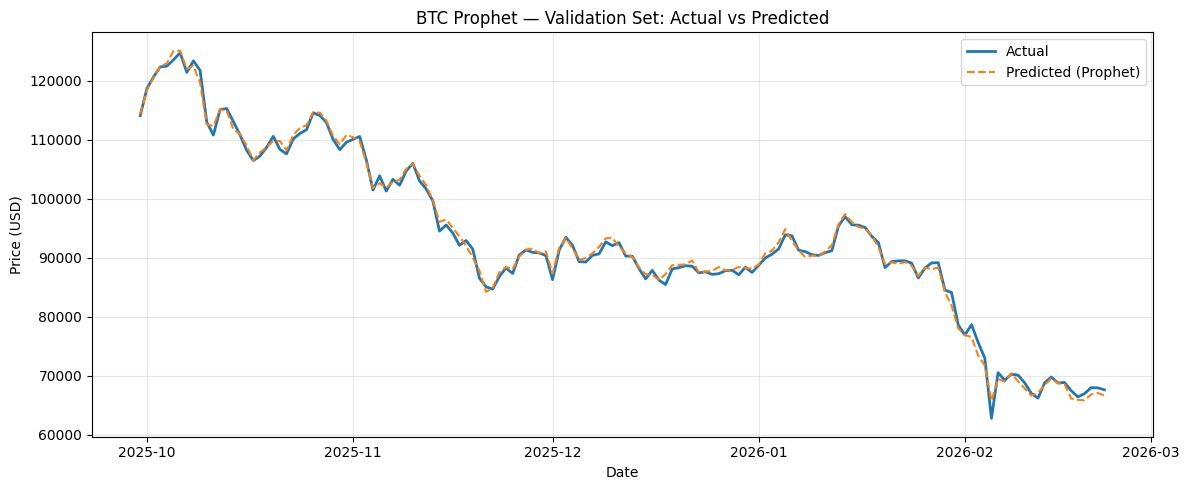

In [7]:
# ── Step 7: Predict on Validation Set ────────────────────────────────────────
# Re-scale and split to get validation portion for evaluation
df_scaled_val, feat_sc_val, tgt_sc_val = _prophet_scale(
    daily_data, features, RESPONSE_VARIABLE, best_scaler_method
)
train_scaled, val_scaled = _prophet_time_split(df_scaled_val, TRAIN_PCT)
val_future = _prophet_make_future(val_scaled, df_scaled_val, features, RESPONSE_VARIABLE)

# Train on training portion for fair validation evaluation
train_df_val = _prophet_build_train_frame(train_scaled, RESPONSE_VARIABLE)
val_model = _prophet_train_single(train_df_val, features, best_params)
preds_df = val_model.predict(val_future)
yhat_scaled = preds_df['yhat'].values
val_preds = _prophet_inverse_target(yhat_scaled, tgt_sc_val, best_scaler_method)

# Ground truth on original scale
y_val_true = daily_data.loc[val_scaled.index, RESPONSE_VARIABLE].values
val_df = pd.DataFrame({'predicted_price': val_preds}, index=val_scaled.index)

# Compute RMSE
rmse, std_rmse = _standardized_rmse(
    pd.Series(y_val_true, index=val_scaled.index), val_preds
)
print(f"Validation RMSE:            {rmse:,.2f}")
print(f"Standardized RMSE (÷ std):  {std_rmse:.4f}")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(val_scaled.index, y_val_true, label='Actual', linewidth=2)
ax.plot(val_df.index, val_df['predicted_price'], label='Predicted (Prophet)', linestyle='--')
ax.set_title(f"{COIN} Prophet — Validation Set: Actual vs Predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Future predictions for next 7 days:
            predicted_price
2026-02-23     67236.777226
2026-02-24     67236.935482
2026-02-25     67326.492766
2026-02-26     67158.945307
2026-02-27     67277.025909
2026-02-28     67280.439251
2026-03-01     67307.705608


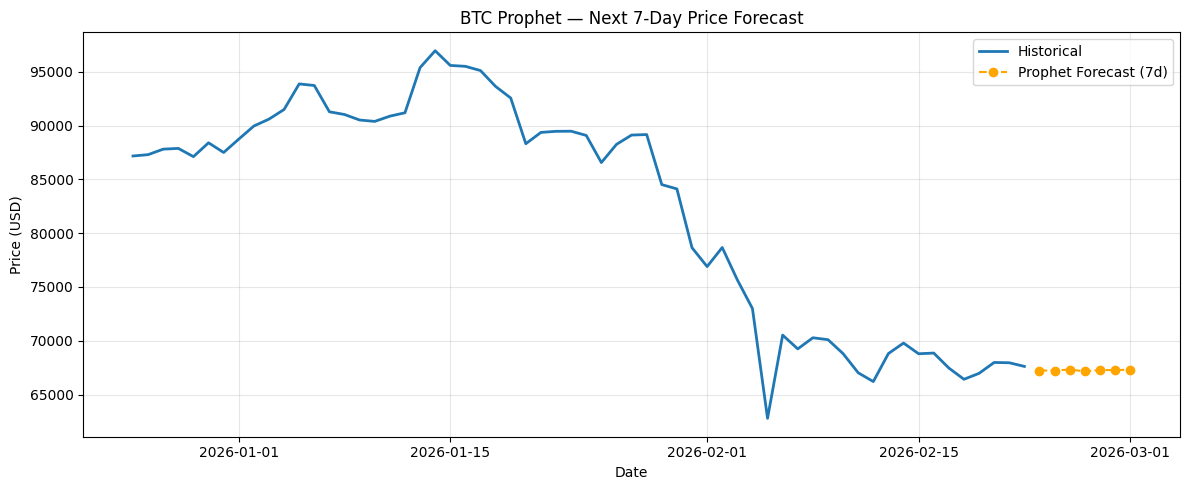

In [8]:
# ── Step 8: Predict Next TEST_DAYS Days ──────────────────────────────────────
future_df = _prophet_future_forecast(
    wrapper, daily_data, features, RESPONSE_VARIABLE, n=TEST_DAYS
)

print(f"Future predictions for next {TEST_DAYS} days:")
print(future_df.to_string())

# Plot future forecast
fig, ax = plt.subplots(figsize=(12, 5))
hist = daily_data[RESPONSE_VARIABLE].iloc[-60:]
ax.plot(hist.index, hist.values, label='Historical', linewidth=2)
ax.plot(future_df.index, future_df['predicted_price'], marker='o',
        linestyle='--', label=f'Prophet Forecast ({TEST_DAYS}d)', color='orange')
ax.set_title(f"{COIN} Prophet — Next {TEST_DAYS}-Day Price Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ── Step 9: Save Metrics ──────────────────────────────────────────────────────
metrics_path = _save_metrics(std_rmse, COIN, 'prophet')

print(f"Metrics (std RMSE) saved to: {metrics_path}")
print(f"\nStandardized RMSE: {std_rmse:.4f}")
print("Done.")